In [5]:
import numpy as np
import pickle
from funcy                     import *
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers        import l2
from keras.utils               import plot_model
import keras.layers as kl

import psutil
import keras


# basic configs
weight_decay = 0.0005 
use_bias = False
weight_init="he_normal" 
padding = 'same'
L2 = keras.regularizers.l2(weight_decay)
conv_config = {'padding':padding,
               'kernel_initializer':weight_init,
               'kernel_regularizer':L2,
               'use_bias':use_bias}

# insuring image data channel is at last axis 
keras.backend.image_data_format()
# keras.backend..set_image_data_format('channels_first')

'channels_last'

In [13]:
# Utility functions.

def ljuxt(*fs):  
    return rcompose(juxt(*fs), list)

def bn():return kl.BatchNormalization()

def relu():return kl.Activation('relu')

def conv(filter_size, kernel_size, stride_size=1):
    return kl.Conv2D(filter_size, kernel_size=kernel_size,strides=stride_size, **conv_config)

def conv3(filter_size):return conv(filter_size, kernel_size=(3,3), stride_size=1)
def conv1(filter_size):return conv(filter_size, kernel_size=(1,1), stride_size=1)

def add():return kl.Add()

def GlobalAvgPool():return kl.GlobalAveragePooling2D()

def avgPool(pool_size=2,strides=2):return kl.AveragePooling2D(pool_size=pool_size,strides=strides)

def dense(unit_size, activation):
    return kl.Dense(unit_size, activation=activation, kernel_regularizer=L2)  

# original layer which is pad the channel size with zeros matrix, 
# ex. padding (None,28,28,1) 2 zeros channels as (None,28,28,3)
class zeroPad(keras.engine.topology.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.l = None
        super(zeroPad, self).__init__(**kwargs)

    def build(self, input_shape):
        super(zeroPad, self).build(input_shape)

    def call(self, x):
        x_shape = x.shape.as_list()
        if self.output_dim == x_shape[-1]:
            return x
        if self.l is None:
            padding = self.output_dim//x_shape[-1]
            self.l = [x] + [kl.K.zeros_like(x) for i in range(padding-1)]
            self.l +=  [kl.K.zeros_like(x)[:,:,:,:self.output_dim - padding*x_shape[-1]] ]
        return kl.concatenate(self.l)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2], self.output_dim)

    
from keras.engine import Layer, InputSpec
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations
import keras.backend as K
class Scale(Layer):
    '''Custom Layer for DenseNet used for BatchNormalization.
    
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:
        out = in * gamma + beta,
    where 'gamma' and 'beta' are the weights and biases larned.
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Tensorflow >= 1.0.0 compatibility
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# VGG16 architecture
![title](https://flyyufelix.github.io/img/vgg16.png)

In [18]:
def vgg16(classes=1000):
    return rcompose(conv3(64),
                    conv3(64),
                    kl.MaxPool2D(2,2),
                    conv3(128),
                    conv3(128),
                    kl.MaxPool2D(2,2),
                    conv3(256),
                    conv3(256),
                    conv3(256),
                    kl.MaxPool2D(2,2),
                    conv3(512),
                    conv3(512),
                    conv3(512),
                    kl.MaxPool2D(2,2),
                    conv3(512),
                    conv3(512),
                    conv3(512),
                    kl.MaxPool2D(2,2),
                    kl.Flatten(),
                    dense(4096,'relu'),
                    dense(4096,'relu'),
                    dense(classes,'relu'),
                    dense(classes,'softmax'),
                   )

def vgg16_FCN(classes=1000):
    return rcompose(conv3(64),
                    conv3(64),
                    kl.MaxPool2D(2,2),
                    conv3(128),
                    conv3(128),
                    kl.MaxPool2D(2,2),
                    conv3(256),
                    conv3(256),
                    conv3(256),
                    kl.MaxPool2D(2,2),
                    rcompose(ljuxt(rcompose(conv3(512),
                                            conv3(512),
                                            conv3(512),
                                            kl.MaxPool2D(2,2),#----------------------------
                                            rcompose(ljuxt(rcompose( conv3(512),#         |
                                                            conv3(512),         #         |
                                                            conv3(512),         #         |
                                                            kl.MaxPool2D(2,2),  #         |
                                                            conv1(4096),
                                                            kl.Dropout(0.4),
                                                            conv1(4096),
                                                            kl.Dropout(0.4),
                                                            conv1(512),
                                                            kl.UpSampling2D(2),#         |
                                                            conv3(512),#
                                                           ),
                                            Scale(),),
                                            add(),
                                            kl.UpSampling2D(2),
                                            conv3(256) )
                                       ),
                             Scale(),),
                             add(),
                             kl.UpSampling2D(2),
                             conv3(classes) ),
                    BilinearUpSampling2D((4,4)),
                    )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 224, 224, 64)      1728      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 224, 224, 64)      36864     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 112, 112, 128)     73728     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 112, 112, 128)     147456    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 128)       0         
__________

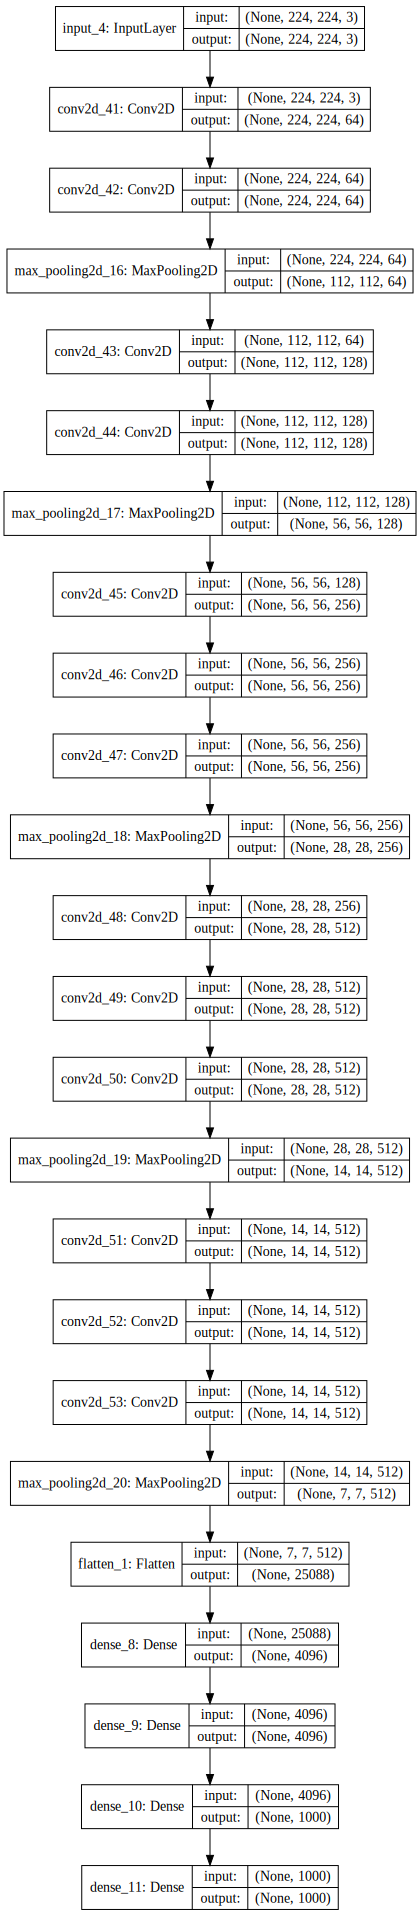

In [19]:
x = kl.Input(shape=(224,224,3))
model = keras.models.Model(x, vgg16()(x) )
model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))